Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf 
import tensorflow_hub as hub

In [2]:
df = pd.read_csv('wine-reviews.csv')

In [3]:
df.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


Removing Columns That Aren't Needed(ex: 'Unnamed')

In [4]:
df = pd.read_csv('wine-reviews.csv', usecols= ['country','description', 'points', 'price','variety','winery'])

In [5]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


In [6]:
df = df.dropna(subset=['description', 'points'])

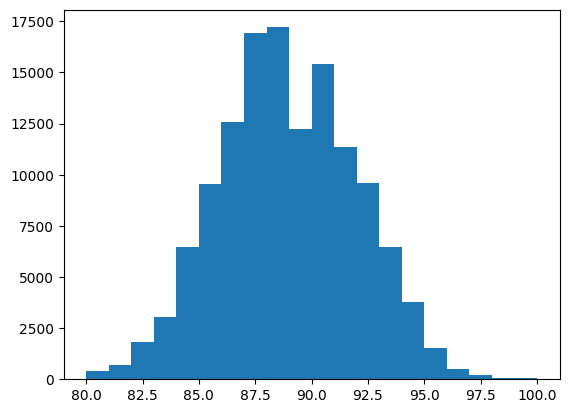

In [7]:
plt.hist(df.points, bins=20)
plt.show()

In [17]:
df.shape

(129971, 6)

In [9]:
df["label"]= (df.points >=90).astype(int)
df = df[['description', 'points', 'label']]

In [12]:
df.tail()

,description,points,label
129966,Notes of honeysuckle and cantaloupe sweeten th...,90,1
129967,Citation is given as much as a decade of bottl...,90,1
129968,Well-drained gravel soil gives this wine its c...,90,1
129969,"A dry style of Pinot Gris, this is crisp with ...",90,1
129970,"Big, rich and off-dry, this is powered by inte...",90,1


In [13]:
train, val, test, = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])

/opt/homebrew/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [15]:
def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
  df = dataframe.copy()
  labels = df.pop('label')
  df = df['description']
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [16]:
train_data = df_to_dataset(train)
val_data = df_to_dataset(val)
test_data = df_to_dataset(test)

In [17]:
list(train_data)[0]

(<tf.Tensor: shape=(1024,), dtype=string, numpy=
 array([b"A blend of Tempranillo, the seldom seen (in Washington) Graciano and Grenache, this wine is direct and fruity with notes of raspberry, char and barrel spices. It's light in style with elegant fruit flavors and grainy tannins with the oak approaching too intrusive.",
        b'Perfumed, soft, easy wine, showing the juicy, fresh side of the two grapes. The fruits are more red than black, open and ripe, but still with youthful exuberance and great freshness.',
        b"Piercing leather, berry and foresty aromas lead to a zesty palate of medicinal cherry and raspberry flavors. The acidity here is high, and so there's some tartness and scour to the palate and finish. Tastes pretty good but rides rough and bumpy.",
        ...,
        b"Smells terrific, even brilliant, with vibrant aromas of lemon-and-lime, vanilla and smoke, but there's an odd flavor that doesn't seem right, suggesting tapioca. If you can get past that, the enormo

Embedding + Model

In [23]:
embedding = "https://www.kaggle.com/models/google/nnlm/frameworks/TensorFlow2/variations/en-dim50/versions/1"
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)

In [26]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(1024, 50), dtype=float32, numpy=
array([[ 0.18119907, -0.2113177 ,  0.07380481, ..., -0.15720978,
        -0.30264166,  0.00760104],
       [ 0.25824124,  0.03919087, -0.06179151, ..., -0.10843127,
         0.10077142,  0.13582702],
       [ 0.54394764, -0.37928754, -0.12677312, ...,  0.08487523,
        -0.18915798,  0.10921885],
       ...,
       [ 0.4290611 , -0.15887062, -0.08307739, ..., -0.25707057,
        -0.27498633,  0.08297714],
       [ 0.21791282, -0.06866615,  0.0085275 , ...,  0.10982203,
         0.04028396, -0.13647465],
       [ 0.45035177, -0.16139075,  0.07094119, ...,  0.14654781,
        -0.13724399,  0.02754777]], dtype=float32)>

In [33]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16,activation='relu'))
model.add(tf.keras.layers.Dense(16,activation='relu'))
model.add(tf.keras.layers.Dense(1,activation='sigmoid'))

In [34]:
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [35]:
model.evaluate(train_data)


102/102 [==============================] - 1s 5ms/step - loss: 0.6925 - accuracy: 0.5167


[0.6924920082092285, 0.516715407371521]

In [36]:
model.evaluate(val_data)

13/13 [==============================] - 0s 6ms/step - loss: 0.6922 - accuracy: 0.5187


[0.6921862363815308, 0.5187351107597351]

In [37]:
history = model.fit(train_data, epochs=10, validation_data=val_data)

Epoch 1/10
102/102 [==============================] - 16s 154ms/step - loss: 0.5444 - accuracy: 0.7086 - val_loss: 0.4093 - val_accuracy: 0.8103
Epoch 2/10
102/102 [==============================] - 16s 154ms/step - loss: 0.3708 - accuracy: 0.8306 - val_loss: 0.3746 - val_accuracy: 0.8242
Epoch 3/10
102/102 [==============================] - 16s 152ms/step - loss: 0.3276 - accuracy: 0.8544 - val_loss: 0.3671 - val_accuracy: 0.8302
Epoch 4/10
102/102 [==============================] - 16s 154ms/step - loss: 0.3022 - accuracy: 0.8685 - val_loss: 0.3697 - val_accuracy: 0.8313
Epoch 5/10
102/102 [==============================] - 16s 154ms/step - loss: 0.2830 - accuracy: 0.8776 - val_loss: 0.3702 - val_accuracy: 0.8317
Epoch 6/10
102/102 [==============================] - 15s 151ms/step - loss: 0.2673 - accuracy: 0.8860 - val_loss: 0.3766 - val_accuracy: 0.8311
Epoch 7/10
102/102 [==============================] - 16s 152ms/step - loss: 0.2528 - accuracy: 0.8931 - val_loss: 0.3840 - val_ac

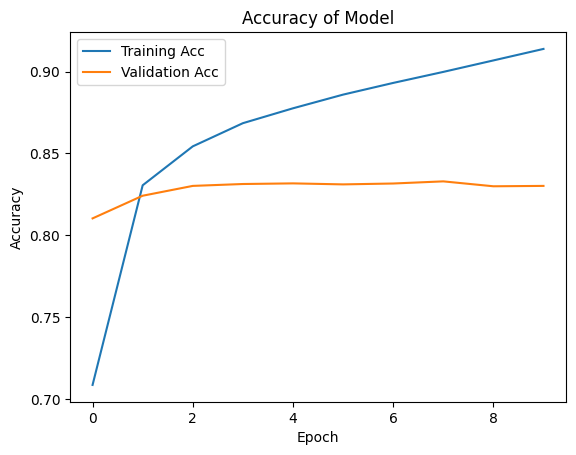

In [40]:
plt.plot(history.history['accuracy'], label='Training Acc')
plt.plot(history.history['val_accuracy'], label='Validation Acc')
plt.title('Accuracy of Model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

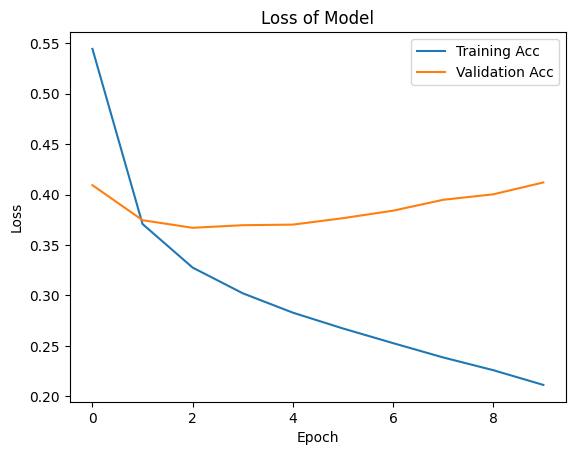

In [41]:
plt.plot(history.history['loss'], label='Training Acc')
plt.plot(history.history['val_loss'], label='Validation Acc')
plt.title('Loss of Model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()